# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Напомним значения столбцов таблицы:

        RowNumber — номер строки таблицы;
        CustomerId — идентификатор клиента;
        Surname — фамилия клиента;
        CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
        Geography — страна проживания клиента (банк межнациональный);
        Gender — пол клиента;
        Age — возраст клиента;
        Tenure — сколько лет клиент пользуется банком;
        Balance — сколько у клиента денег на счетах в банке;
        NumOfProduct — число услуг банка, которыми воспользовался клиент;
        HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
        IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);
        EstimatedSalary — предполагаемая заработная плата клиента;
        Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).
        


Для начала импортируем библиотеки, которые нам понадобятся:

In [62]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline




Итак, прочитаем нашу таблицу:

In [63]:
churn_data = pd.read_csv('data/churn.csv')
display(churn_data.head())
display(churn_data.info())
display(churn_data.describe())

#churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [64]:

#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = churn_data.dtypes
num_features = list(types[(types != 'object')].index)
print(num_features)

#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = churn_data.dtypes
cat_features = list(types[(types == 'object')].index)
print(cat_features)

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
['Surname', 'Geography', 'Gender']


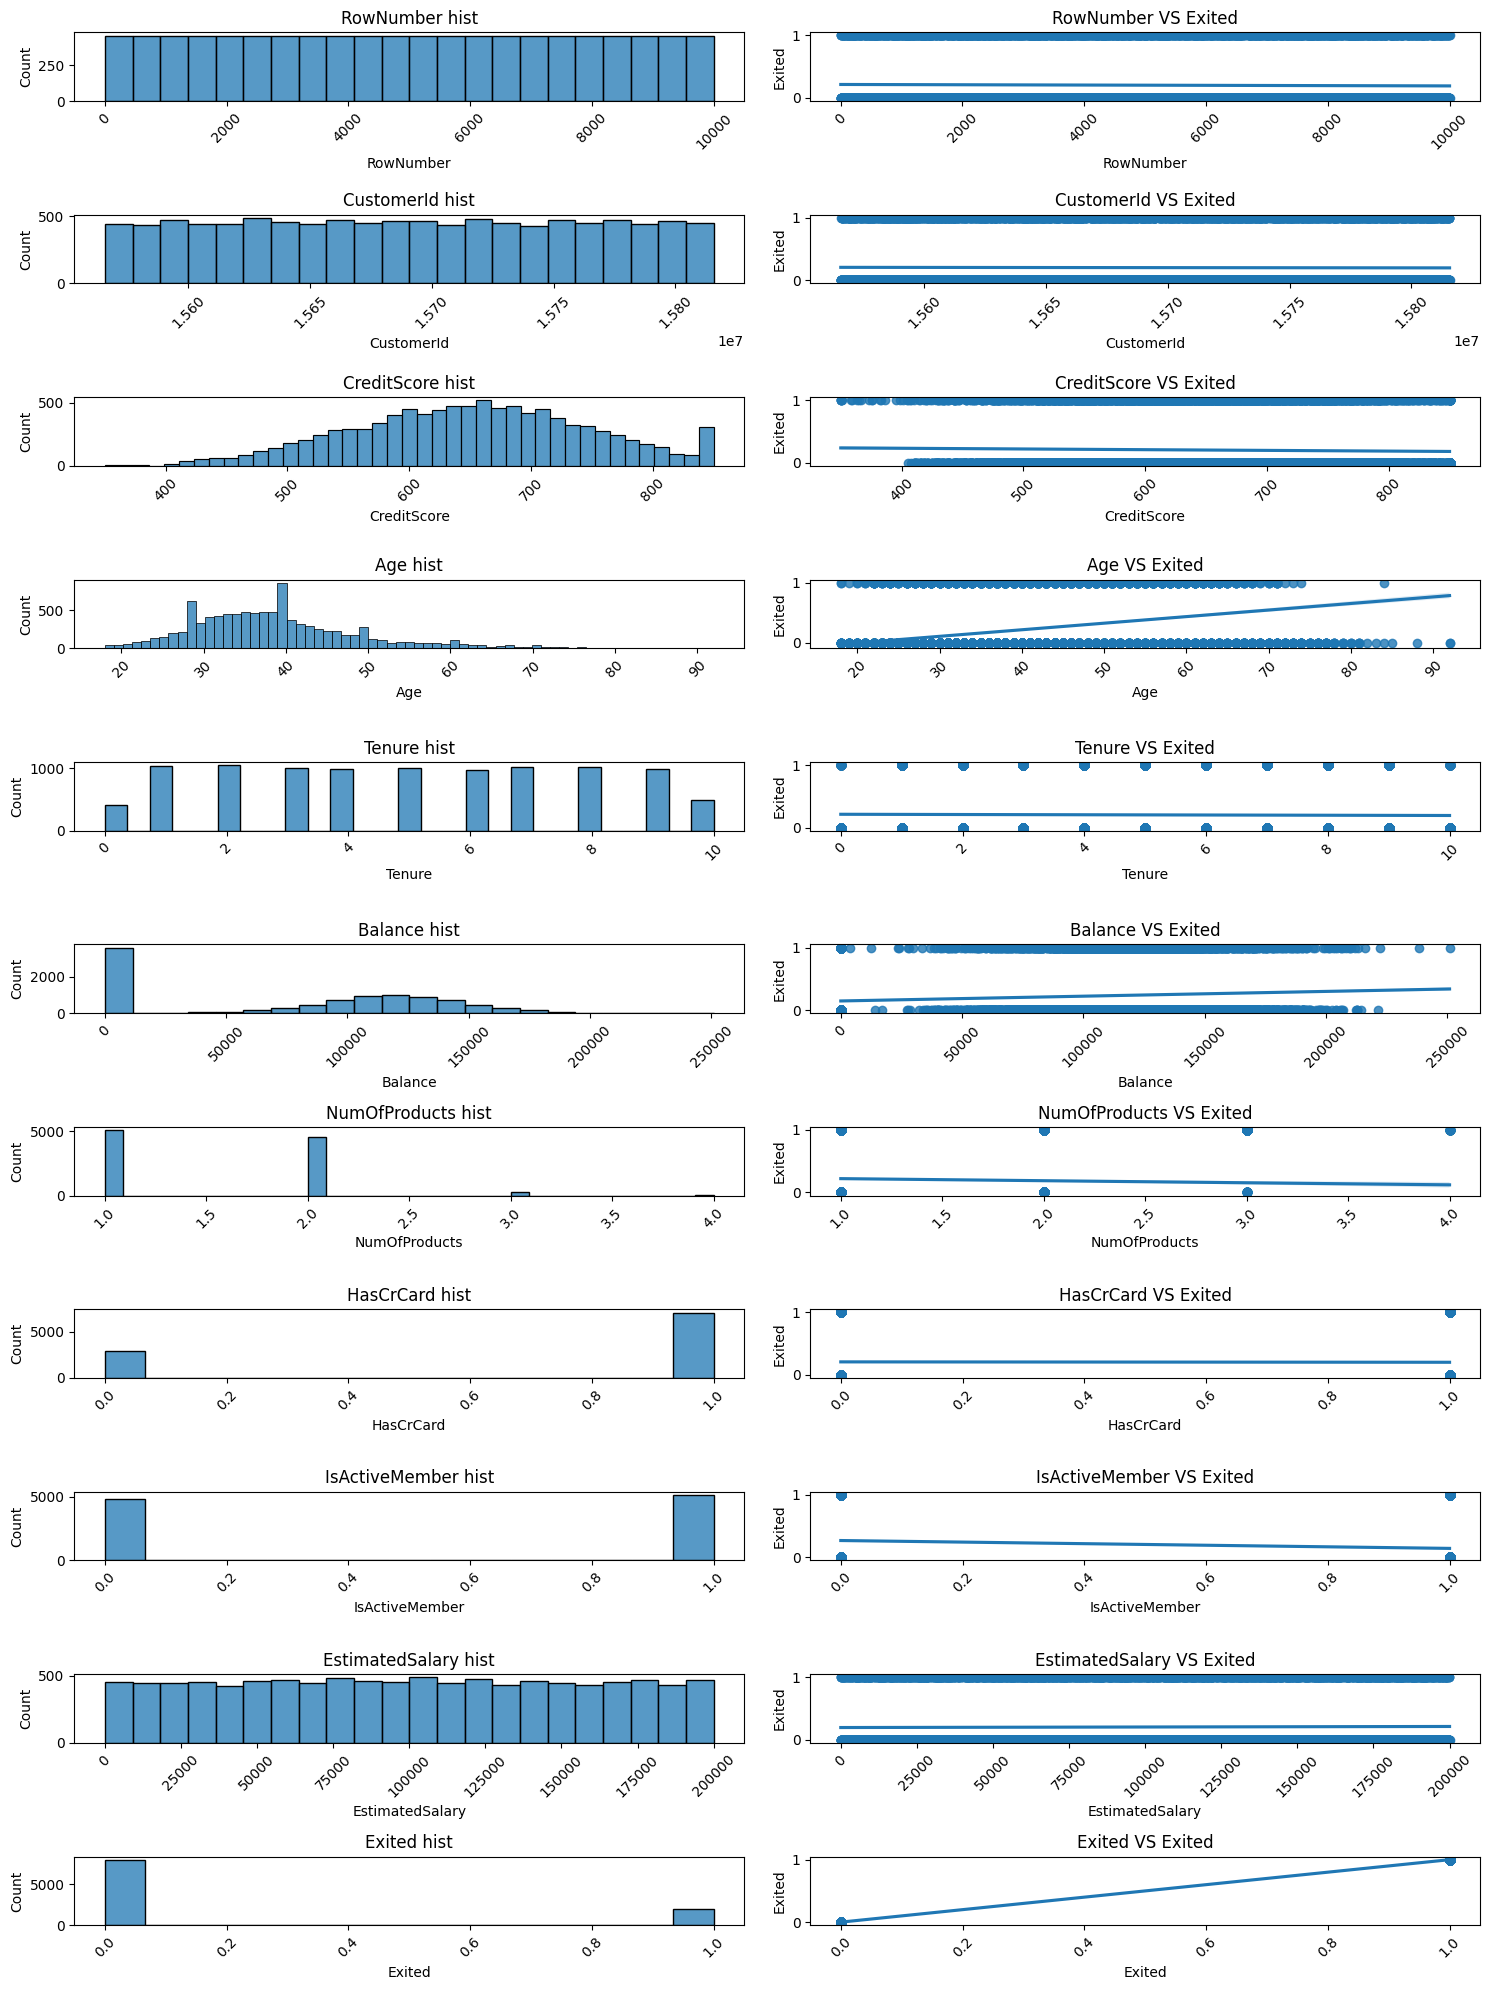

In [65]:
# Ваш код здесь

n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей

#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=churn_data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS Exited'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

C:\Users\kot\AppData\Local\Temp\ipykernel_2944\1935899909.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(churn_data.corr(), annot=True);


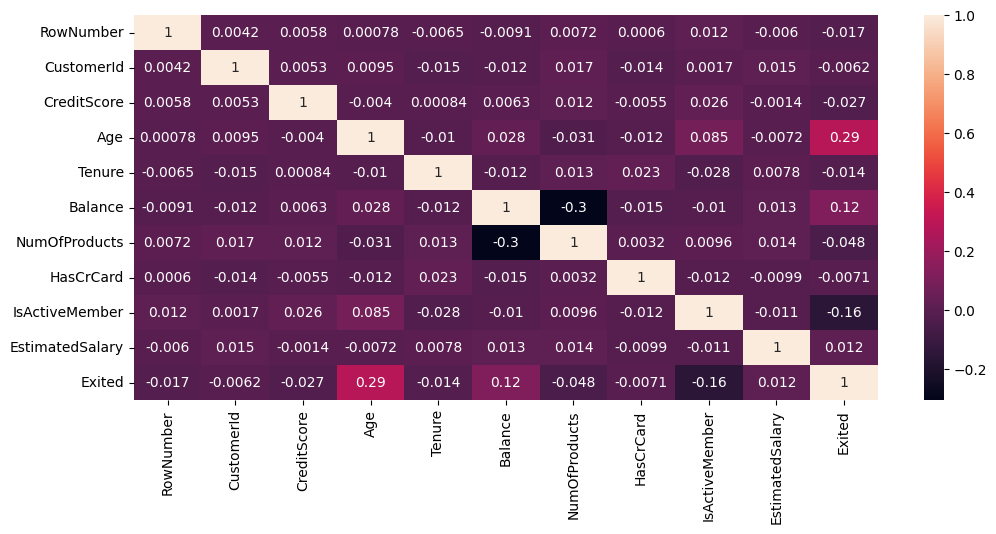

In [66]:
#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(churn_data.corr(), annot=True);

Графики для категориальных аттрибутов

In [67]:
#sns.catplot(data=churn_data, x='Geography', y='Exited', kind="bar")


C:\Users\kot\AppData\Local\Temp\ipykernel_2944\3297298635.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_target = churn_data.corr()['Exited'].abs().sort_values()


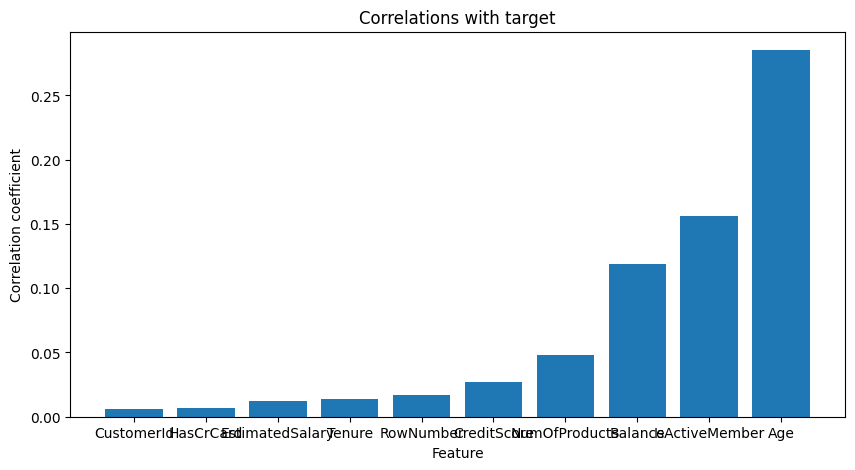

In [68]:
#Вычисляем модуль корреляции
corr_with_target = churn_data.corr()['Exited'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('Exited')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [69]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [70]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [71]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [72]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [73]:
# Ваш код здесь
churn_data_copy = churn_data.copy()
churn_data_copy['BalanceSalaryRatio'] = churn_data_copy['Balance']/churn_data_copy['EstimatedSalary']
churn_data_copy['TenureByAge'] = churn_data_copy['Tenure']/churn_data_copy['Age']
churn_data_copy['CreditScoreGivenAge'] = churn_data_copy['CreditScore']/churn_data_copy['Age']
churn_data_copy['GenderBnary'] = churn_data_copy['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
churn_data_copy = churn_data_copy.drop(['Gender'], axis=1)

display(churn_data_copy.head())
display(churn_data_copy.info())
display(churn_data_copy.describe())

churn_data = churn_data_copy.copy()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,GenderBnary
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,1
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Age                  2509 non-null   int64  
 2   Tenure               2509 non-null   int64  
 3   Balance              2509 non-null   float64
 4   NumOfProducts        2509 non-null   int64  
 5   HasCrCard            2509 non-null   int64  
 6   IsActiveMember       2509 non-null   int64  
 7   EstimatedSalary      2509 non-null   float64
 8   Exited               2509 non-null   int64  
 9   BalanceSalaryRatio   2509 non-null   float64
 10  TenureByAge          2509 non-null   float64
 11  CreditScoreGivenAge  2509 non-null   float64
 12  GenderBnary          2509 non-null   int64  
dtypes: float64(5), int64(8)
memory usage: 274.4 KB


None

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,GenderBnary
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Tenure'),
  Text(1, 0, 'HasCrCard'),
  Text(2, 0, 'Balance'),
  Text(3, 0, 'CreditScore'),
  Text(4, 0, 'EstimatedSalary'),
  Text(5, 0, 'BalanceSalaryRatio'),
  Text(6, 0, 'NumOfProducts'),
  Text(7, 0, 'GenderBnary'),
  Text(8, 0, 'TenureByAge'),
  Text(9, 0, 'IsActiveMember'),
  Text(10, 0, 'CreditScoreGivenAge'),
  Text(11, 0, 'Age')])

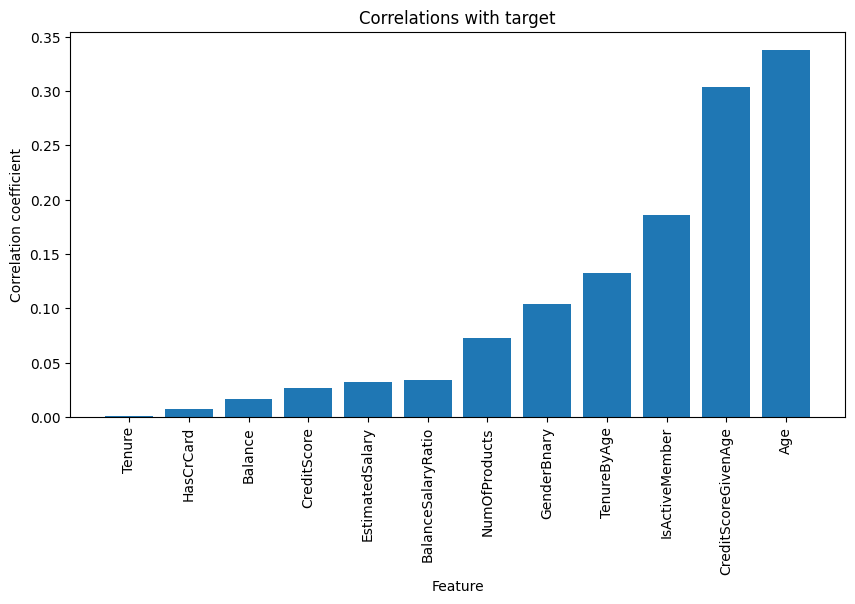

In [74]:
#Вычисляем модуль корреляции
corr_with_target = churn_data.corr()['Exited'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('Exited')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y
plt.xticks(rotation=90)

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [75]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [76]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [77]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [78]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [79]:
# Ваш код здесь
scaler = preprocessing.MinMaxScaler()
display(scaler.fit(X_train))
print(scaler.data_max_)
display(scaler.transform(X_train))

X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

MinMaxScaler()

[8.50000000e+02 8.40000000e+01 1.00000000e+01 2.14346960e+05
 4.00000000e+00 1.00000000e+00 1.00000000e+00 1.99970740e+05
 1.06146554e+04 5.00000000e-01 4.63888889e+01 1.00000000e+00]


array([[0.888     , 0.59090909, 0.3       , ..., 0.10526316, 0.19173944,
        1.        ],
       [0.502     , 0.12121212, 0.7       , ..., 0.53846154, 0.42046834,
        0.        ],
       [0.97      , 0.03030303, 0.4       , ..., 0.4       , 0.8844874 ,
        1.        ],
       ...,
       [0.584     , 0.57575758, 0.6       , ..., 0.21428571, 0.13034526,
        0.        ],
       [0.528     , 0.25757576, 0.6       , ..., 0.34285714, 0.28170728,
        0.        ],
       [0.784     , 0.04545455, 0.1       , ..., 0.0952381 , 0.7247065 ,
        0.        ]])

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 


По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.
>(F-мера) — это взвешенное среднее гармоническое между precision и recall
>
>мы хотим найти как можно больше клиентов, которые потенциально могут уйти от нас. Чтобы повысить их лояльность, мы планируем использовать ресурсы колл-центра. Однако они ограничены и мы не можем >звонить всем клиентам. Определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных >клиентов или тех, кто уйдёт с большей вероятностью.
>Метрика F1 равна своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет >близка к 0, то и будет близка к 0. Т.е. метрика F1 больше всего подходит под условия задачи, так как она показывает и ложноотрицателный и ложноположительные ошибки 

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [80]:
# Ваш код здесь
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty="l2", #тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
    C=1

    
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scale, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scale)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scale)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1271
           1       0.63      0.40      0.49       610

    accuracy                           0.73      1881
   macro avg       0.69      0.64      0.65      1881
weighted avg       0.72      0.73      0.71      1881

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       424
           1       0.62      0.38      0.47       204

    accuracy                           0.72       628
   macro avg       0.68      0.63      0.64       628
weighted avg       0.71      0.72      0.70       628



> Ваши выводы и рассуждения — *здесь*.

при стандартных параметрах модели (L2, C=1) модель недобучена так как F1 меньше 0.5
изменим параметры и посмотрим результат

In [81]:
# Ваш код здесь
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty="l1", #тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
    C=10

    
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scale, y_train)



#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scale)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scale)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.44      0.52       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.67      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



1. для  регулиризации L2, уменьшение C ведет к худщшему результату с 49% до 42% для целевой метрики (на трениновочной выборке), при увелечении С до 10, метрика улучшается с 49; до 51 . 
2. для алгаритма оптимизации sag, доступен только L2 регулиризация. изменение на saga и использование l1 даёт еще 1 процент присроста

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [82]:
# Ваш код здесь
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scale)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scale)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scale)

#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

print(type(X_train_poly))
print(type(X_test_poly))

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty="l1", #тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
    C=10   
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_poly)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

(1881, 454)
(628, 454)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1271
           1       0.77      0.67      0.72       610

    accuracy                           0.83      1881
   macro avg       0.81      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       424
           1       0.71      0.64      0.67       204

    accuracy                           0.80       628
   macro avg       0.77      0.76      0.76       628
weighted avg       0.80      0.80      0.80       628



c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


> Ваши выводы и рассуждения — *здесь* 

1. poly  существенно улучшает результаты модели, повышая до 66% и 64% (тренировочная и тестовая выборка) 
2. измениние оптимазации с sag на saga увеличивет точность до 68% и 66% (тренировочная и тестовая выборка) 
3. для  регулиризации L1, уменьшение C ведет к худщшему результату , при увелечении С до 10, метрика улучшается до 72% и 68%. 

попробуем найти зависимость от значения С и построим графики


In [83]:
#Создаём список из 8 возможных значений 
c_list = [0.1, 0.25, 0.5, 0.75, 1, 2, 5, 10]

#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for c_arg in c_list:
    print(c_arg)
    #Создаём объект класса линейной регрессии с L1-регуляризацией
    log_reg = linear_model.LogisticRegression(
    C=c_arg,
    penalty='l1', #тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация)
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    )
    #Обучаем модель
    log_reg.fit(X_train_poly, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_pred = log_reg.predict(X_train_poly)
 
    #Делаем предсказание для тестовой выборки
    y_test_pred = log_reg.predict(X_test_poly)

    #Рассчитываем коэффициенты детерминации для двух выборок и добавляем их в списки
    train_scores.append(metrics.f1_score(y_train, y_train_pred))
    test_scores.append(metrics.f1_score(y_test, y_test_pred))

0.1
0.25
0.5


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.75


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


2


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


5


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


10


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


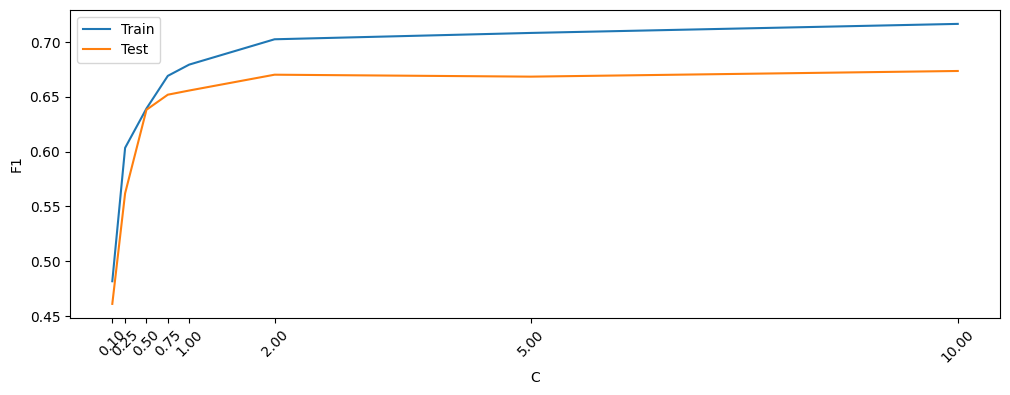

In [85]:
#Визуализируем изменение F1 в зависимости от C
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(c_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(c_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('C') #название оси абсцисс
ax.set_ylabel('F1') #название оси ординат
ax.set_xticks(c_list) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

0      0.166451
1      0.289753
2      0.010004
3      0.014280
4      0.468153
         ...   
623    0.151653
624    0.301137
625    0.252086
626    0.043098
627    0.004843
Length: 628, dtype: float64

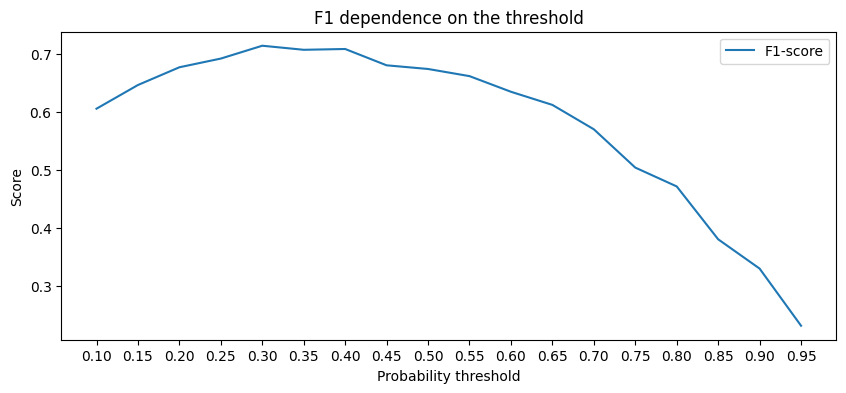

In [86]:
# Ваш код здесь
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])
display(y_test_proba_pred)

# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores.append(score)

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();




In [87]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.3

y_train_proba_pred = pd.Series(log_reg.predict_proba(X_train_poly)[:, 1])
y_test_proba_pred = pd.Series(log_reg.predict_proba(X_test_poly)[:, 1])

y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)


#Считаем метрики
print(metrics.classification_report(y_train, y_train_pred_opt))
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1271
           1       0.63      0.85      0.72       610

    accuracy                           0.79      1881
   macro avg       0.77      0.80      0.78      1881
weighted avg       0.82      0.79      0.80      1881

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       424
           1       0.62      0.84      0.71       204

    accuracy                           0.78       628
   macro avg       0.76      0.80      0.77       628
weighted avg       0.81      0.78      0.79       628



максимум метрики F1 находиться при вероятность 0,30 и дает значение метрики в 83%/72% на тренировочной и 82%/71% на тестовой выбрке !

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [39]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [28]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [40]:
# Ваш код здесь
#Создаём объект класса DecisionTreeClassifier
dt_clf_noilim = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=3,
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf_noilim.fit(X_train,y_train)

#Делаем предсказание класса для всего набора данных train и test
y_train_pred = dt_clf_noilim.predict(X_train)
y_test_pred = dt_clf_noilim.predict(X_test)
#Выводим отчёт о метриках классификации для train
print(metrics.classification_report(y_train, y_train_pred))
#Выводим отчёт о метриках классификации для test
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       424
           1       0.54      0.51      0.53       204

    accuracy                           0.70       628
   macro avg       0.66      0.65      0.65       628
weighted avg       0.70      0.70      0.70       628



> Ваши выводы и рассуждения — *здесь*
>модель является переобученной, так как из за отсутствия ограничения на глубину, модель идеально подстроилась под обучающую выборку (все метрики получились 1.00) но дает очень плохой результат для тестовой. 

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [41]:
# Ваш код здесь
#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train,y_train)

#Делаем предсказание класса для всего набора данных train и test
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)
#Выводим отчёт о метриках классификации для train
print(metrics.classification_report(y_train, y_train_pred))
#Выводим отчёт о метриках классификации для test
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1271
           1       0.80      0.65      0.72       610

    accuracy                           0.83      1881
   macro avg       0.82      0.79      0.80      1881
weighted avg       0.83      0.83      0.83      1881

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       424
           1       0.72      0.59      0.65       204

    accuracy                           0.79       628
   macro avg       0.77      0.74      0.75       628
weighted avg       0.79      0.79      0.79       628



> Ваши выводы и рассуждения — *здесь*
модель показывает достаточно устойчвые результаты для метрики F1. На тренировочной выборке мы получили значения 0.88 и 0.72, что меньше чем в первой попытке, но это показывает что по крайней мере мы избежали переобучения. на тестовой выборке мы видим 0.85 и 0.65 что гораздо лучше чем первый вариант

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [42]:
# Ваш код здесь
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    #max_features='sqrt',
    random_state=42       
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)

#Делаем предсказание класса для всего набора данных train и test
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)
#Выводим отчёт о метриках классификации для train
print(metrics.classification_report(y_train, y_train_pred))
#Выводим отчёт о метриках классификации для test
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1271
           1       0.86      0.63      0.73       610

    accuracy                           0.85      1881
   macro avg       0.85      0.79      0.81      1881
weighted avg       0.85      0.85      0.84      1881

              precision    recall  f1-score   support

           0       0.81      0.90      0.86       424
           1       0.74      0.57      0.64       204

    accuracy                           0.79       628
   macro avg       0.78      0.74      0.75       628
weighted avg       0.79      0.79      0.79       628



> Ваши выводы и рассуждения — *здесь*:

ансамблевая модель тоже показывает достаточно устойчвые результаты для метрики F1. На тренировочной выборке мы получили значения 0.89 и 0.73, что лучше чем для одного дерева, но на тестовой выборке мы видим 0.85 и 0.64 что гораздо примерно тоже самое

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

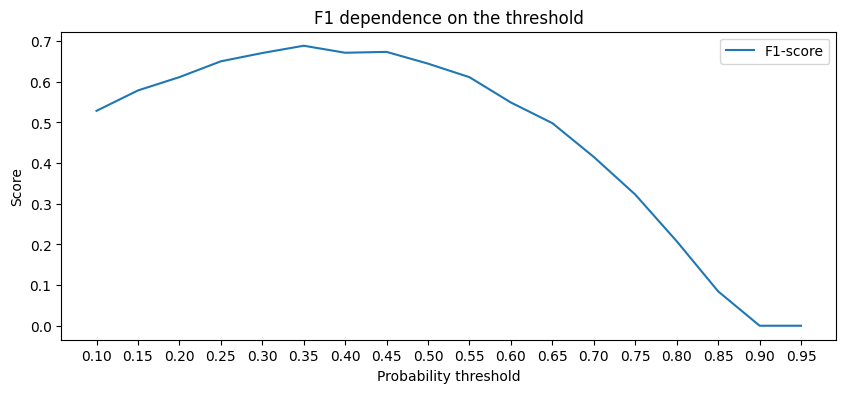

In [43]:
# Ваш код здесь
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
#display(y_test_proba_pred)

# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores.append(score)

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

In [44]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35

y_train_proba_pred = pd.Series(rf_clf.predict_proba(X_train)[:, 1])
y_test_proba_pred = pd.Series(rf_clf.predict_proba(X_test)[:, 1])

y_train_pred_opt = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)


#Считаем метрики
print(metrics.classification_report(y_train, y_train_pred_opt))
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1271
           1       0.73      0.80      0.76       610

    accuracy                           0.84      1881
   macro avg       0.81      0.83      0.82      1881
weighted avg       0.84      0.84      0.84      1881

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       424
           1       0.63      0.76      0.69       204

    accuracy                           0.78       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.78      0.78       628



> Ваши выводы и рассуждения — *здесь*
максимум метрики F1 находиться при вероятность 0,35 и дает значение метрики в 88%/72% на тренировочной и 82%/69% на тестовой выбрке, что является лучшим результатом

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [45]:
display(X_train)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,GenderBnary
3827,794,57,3,117056.46,1,1,0,93336.93,1.254128,0.052632,13.929825,1
1004,601,26,7,105514.69,2,1,0,50070.59,2.107319,0.269231,23.115385,0
2945,835,20,4,124365.42,1,0,0,180197.74,0.690161,0.200000,41.750000,1
6231,631,48,1,106396.48,1,1,1,150661.42,0.706196,0.020833,13.145833,1
8277,624,40,3,149961.99,2,1,0,104610.86,1.433522,0.075000,15.600000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5559,850,36,5,119984.07,1,1,0,191535.11,0.626434,0.138889,23.611111,1
3716,665,27,2,147435.96,1,0,0,187508.06,0.786291,0.074074,24.629630,0
3885,642,56,6,103244.86,2,1,0,143049.72,0.721741,0.107143,11.464286,0
983,614,35,6,128100.28,1,0,0,69454.24,1.844384,0.171429,17.542857,0


In [127]:
# Ваш код здесь
# лучший рез-т был достигнут линейной регрессией с полиномиальными аттрибутами и при пороге вероятности 0.30  

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)


test_data = {
    'CreditScore': [601],
    'Gender': ['Male'],
    'Age': [42],
    'Tenure': [1],
    'Balance': [98495.72],
    'NumOfProducts': [1],
    'HasCrCard': [1],
    'IsActiveMember': [0],
    'EstimatedSalary': [40014.76]
}

#преобразуем в датафрэйм
test_data_df = pd.DataFrame.from_dict(test_data)

#добавим аттрибуты:
test_data_df['BalanceSalaryRatio'] = test_data_df['Balance']/test_data_df['EstimatedSalary']
test_data_df['TenureByAge'] = test_data_df['Tenure']/test_data_df['Age']
test_data_df['CreditScoreGivenAge'] = test_data_df['CreditScore']/test_data_df['Age']
test_data_df['GenderBnary'] = test_data_df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
test_data_df = test_data_df.drop(['Gender'], axis=1)


display(test_data_df)

#проведем скалирование:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
#X_test_scale = scaler.transform(X_test)

X_search_scale = scaler.transform(test_data_df)

#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scale)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scale)
#Генерируем полиномиальные признаки для тестовой выборки
#X_test_poly = poly.transform(X_test_scale)
X_search_poly = poly.transform(X_search_scale)

#Выводим результирующие размерности таблиц
#print(X_test_poly.shape)
print('Train shape: {}'.format(X_train_poly.shape))
print('Test shape: {}'.format(X_search_poly.shape))

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='saga', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty="l1", #тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
    C=10   
)

#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_poly, y_train)


#y_search_predict = log_reg.predict(X_search_poly)
#print('Predicted class: {}'.format(y_search_predict))
# predict_proba() — для предсказания вероятности принадлежности к каждому из классов:


#Делаем предсказание для тестовой выборки
y_search_proba_predict = log_reg.predict_proba(X_search_poly)
print('Predicted prababilities: {}'.format(np.round(y_search_proba_predict, 3)))
#Задаём оптимальный порог вероятностей
threshold_opt = 0.3
y_search_proba_pred = pd.Series(log_reg.predict_proba(X_search_poly)[:, 1])
y_search_pred_opt = list(y_search_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0))

print('Predicted optimal class: {} with probability of {}'.format(y_search_pred_opt[0], np.round(y_search_proba_predict[0][1], 3)))



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,GenderBnary
0,601,42,1,98495.72,1,1,0,40014.76,2.461485,0.02381,14.309524,1


Train shape: (1881, 454)
Test shape: (1, 454)
Predicted prababilities: [[0.335 0.665]]
Predicted optimal class: 1 with probability of 0.665


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
